## Business Problem

### Business situation

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### Business Understanding & Solution planning

- Motivation: Sales forecasting was requested by CFO on monthly meeting to all sales managers
- Main stakeholder: CFO
- Root cause: In order to evaluate solution, talking to CFO he has made clear that wants to define the budget investiment to refurbish all stores and sales forecast will support it => in this case, the sales forecast it's a suitable solution
- Solution format: 
 - Granularity: information by store by day for the next 6 weeks
 - Problem type: sales forecast
 - Potential methods: time series, regression
 - Deliverables: Will constructed a dashboard to 
   -Total sales forecasted by store for next 6 weeks
   -Sales evolution for next 6 weeks by store


- SAPE:
- Saída (produto final)
 - Resposta para pergunta:
 - Formato Entrega:
 - Local:
- Processo (passo a passo)
 - Coletar os dados das vendas das lojas
 - Avaliar qualidade dos dados

- Entrada:
 - Python 3.9
 - Jupyter Nb
 - Kaggle data
 - 

### Data fields

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## 0.Imports

In [153]:
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
import datetime
import random
import pickle
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import requests
import json
from flask import Flask, request,Response

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor
from boruta                import BorutaPy
from scipy                 import stats
from IPython.core.display  import HTML
from IPython.display       import Image

### 0.1 Helper Functions

In [154]:
def jupyter_settings():
    #%matplotlib inline
    #%pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:95% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.float_format', lambda x: '%.4f' % x)    
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    pd.set_option('display.float_format', lambda x: '%.5f' % x)

#jupyter_settings()

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)    


def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def mean_percentage_error(y, yhat):
    return np.mean(((y - yhat)/y))

def ml_error(model_name, y, yhat ):
    
    mae= mean_absolute_error(y, yhat)
    mape= mean_absolute_percentage_error(y, yhat)
    rmse= np.sqrt(mean_squared_error(y, yhat))
    mpe= mean_percentage_error(y, yhat)
    
    return pd.DataFrame({'Model':model_name,
                         'MAE':mae,
                         'MAPE':mape, 
                         'RMSE':rmse,
                         'MPE':mpe},
                         index=[0])

def cross_validation(model_name, model, xtraining, kfold, verbose=False):
    """
    Performs cross-validation of a given machine learning model using k-fold methodology. Calculates and returns the mean and standard deviation of the MAE, MAPE, and RMSE metrics for the model's performance across all k-fold iterations.

    Args:
        model_name (str): A name to identify the model being used.
        model: A machine learning model object that has the 'fit' and 'predict' methods.
        xtraining (pandas.DataFrame): A pandas DataFrame containing the training dataset.
        kfold (int): The number of folds to be used for the cross-validation.
        verbose (bool, optional): If True, prints the current k-fold number during each iteration. Default is False.

    Returns:
        pandas.DataFrame: A pandas DataFrame containing the mean and standard deviation of the MAE, MAPE, and RMSE metrics for the model's performance across all k-fold iterations.

    Example:
        cross_validation('Random Forest', RandomForestRegressor(n_estimators=100), X_train, 5, verbose=True)
    """

    # Initializing empty metrics list
    mae_list=[]
    mape_list=[]
    rmse_list =[]

    for k in reversed(range(1,kfold+1)):
        
        if verbose:
            print('\n'+ model_name +'K-fold number: {}'.format(k))

        # Calculate the start and end date for the validation dataset and split
        val_start_date = xtraining['date'].max() - datetime.timedelta(days=k*6*7)
        val_end_date = xtraining['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        training = xtraining[xtraining['date'] < val_start_date]
        validation = xtraining[( xtraining['date'] >= val_start_date) & ( xtraining['date'] <= val_end_date)]

        x_training = training.drop(['sales','date'],axis=1)
        y_training = training['sales']

        x_validation = validation.drop(['sales','date'],axis=1)
        y_validation = validation['sales']
       
        # Training model
        m = model.fit(x_training,y_training)

        # Predict
        yhat_m = m.predict(x_validation)

        # Calculate the performance metrics for this loop
        m_result = ml_error(model_name,  np.expm1(y_validation), np.expm1(yhat_m))
        
        if verbose:
            print(m_result)

        # Append on metrics list
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name':model_name,
        'MAE CV': np.round(np.mean(mae_list),2).astype('str') + ' +/- ' + np.round(np.std(mae_list),2).astype('str'),
        'MAPE CV': np.round(np.mean(mape_list),2).astype('str') + ' +/- ' + np.round(np.std(mape_list),2).astype('str'),
        'RMSE CV': np.round(np.mean(rmse_list),2).astype('str') + ' +/- ' + np.round(np.std(rmse_list),2).astype('str')
        },index=[0])

### 0.2 Loading Data

In [155]:
df_store_raw = pd.read_csv('C:\\Users\\marco\\OneDrive\\Documents\\repos\\ds_em_producao\\rossmann-sales-prediction\\datasets\\store.csv',low_memory=False)
df_sales_raw = pd.read_csv('C:\\Users\\marco\\OneDrive\\Documents\\repos\\ds_em_producao\\rossmann-sales-prediction\\datasets\\train.csv',low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw,df_store_raw,on='Store',how='left')

## 1. Data description

In [156]:
df = df_raw.copy()

### 1.1 Rename Columns

In [157]:
#transform to snake_case
cols_old = df.columns

snake_case = lambda x: inflection.underscore(x)

cols_new = list(map(snake_case,cols_old))
df.columns = cols_new

### 1.2 Data dimension

In [158]:
print("Dataset has {} rows".format(df.shape[0]))
print("Dataset has {} attributes".format(df.shape[1]))

Dataset has 1017209 rows
Dataset has 18 attributes


### 1.3 Data types

In [159]:
df.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [160]:
df['date'] = pd.to_datetime(df['date'],format="%Y-%m-%d")

### 1.4 Dealing with missing values

First of all, it's important to understand why those values are missing. Afterwards, we can decide how to handle these missing values, mainly through: dropping rows/columns (depending on the volume, we can loose a lot of data and it's not recommended), inputing values with a few techniques such as inputting statistics (means, medians, mode), inputing values using assumptions through business thinking (it can lead to ML models underperforming), inputing values using ML techniques. 

In [161]:
df.isna().sum()/df.shape[0]

store                          0.00
day_of_week                    0.00
date                           0.00
sales                          0.00
customers                      0.00
open                           0.00
promo                          0.00
state_holiday                  0.00
school_holiday                 0.00
store_type                     0.00
assortment                     0.00
competition_distance           0.00
competition_open_since_month   0.32
competition_open_since_year    0.32
promo2                         0.00
promo2_since_week              0.50
promo2_since_year              0.50
promo_interval                 0.50
dtype: float64

In [162]:
#CompetitionDistance - distance in meters to the nearest competitor store
# ** Assumption ** => If missing, replace for double max value in dataset
#df['competition_distance'].max() * 2 #max distance = 151720

df['competition_distance'] = df['competition_distance'].apply(lambda x: 150000 if pd.isna(x) else x)

In [163]:
#CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
# **Assumption** => we will copy sale date to competetition open since month/year

df['competition_open_since_month'] = df.apply(lambda x: x['date'].month if pd.isna(x['competition_open_since_month'])
                                                                                   else x['competition_open_since_month'],axis=1)

df['competition_open_since_year'] = df.apply(lambda x: x['date'].year if pd.isna(x['competition_open_since_year'])
                                                                                   else x['competition_open_since_year'],axis=1)

In [164]:
#Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

#Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
df['promo2_since_week'] = df.apply(lambda x: x['date'].week if pd.isna(x['promo2_since_week']) else x['promo2_since_week'],axis=1)

df['promo2_since_year'] = df.apply(lambda x: x['date'].year if pd.isna(x['promo2_since_year']) else x['promo2_since_year'],axis=1)



In [165]:
#PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

df['promo_interval'].fillna(0, inplace=True)

#translates month (in numbers) to month (in string) and check in a new attribute if sale was in active promo

month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df['month_map'] = df['date'].dt.month.map(month_map)
df['is_promo'] = df[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


In [166]:
df.isna().sum()/df.shape[0]

store                          0.00
day_of_week                    0.00
date                           0.00
sales                          0.00
customers                      0.00
open                           0.00
promo                          0.00
state_holiday                  0.00
school_holiday                 0.00
store_type                     0.00
assortment                     0.00
competition_distance           0.00
competition_open_since_month   0.00
competition_open_since_year    0.00
promo2                         0.00
promo2_since_week              0.00
promo2_since_year              0.00
promo_interval                 0.00
month_map                      0.00
is_promo                       0.00
dtype: float64

### 1.5 Change Types

In [167]:
df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [168]:
df['competition_open_since_month'] = df['competition_open_since_month'].astype('int64')
df['competition_open_since_year'] = df['competition_open_since_year'].astype('int64')

df['promo2_since_week'] = df['promo2_since_week'].astype('int64')
df['promo2_since_year'] = df['promo2_since_year'].astype('int64')

In [169]:
df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### 1.6 Descriptive statistics

In [170]:
num_attr = df.select_dtypes(include=['int64','float64'])
cat_attr = df.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

#### 1.7.1 Numerical Attributes

In [171]:
num_att_metrics = num_attr.agg(["mean","median","std","min","max","skew","kurtosis"]).T.reset_index().rename(columns= {'index' : 'features'})

In [172]:
num_att_metrics

,features,mean,median,std,min,max,skew,kurtosis
0,store,558.43,558.00,321.91,1.00,1115.00,-0.00,-1.20
1,day_of_week,4.00,4.00,2.00,1.00,7.00,0.00,-1.25
2,sales,5773.82,5744.00,3849.93,0.00,41551.00,0.64,1.78
3,customers,633.15,609.00,464.41,0.00,7388.00,1.60,7.09
4,open,0.83,1.00,0.38,0.00,1.00,-1.76,1.09
5,promo,0.38,0.00,0.49,0.00,1.00,0.49,-1.76
6,school_holiday,0.18,0.00,0.38,0.00,1.00,1.68,0.82
7,competition_distance,5805.58,2330.00,10654.37,20.00,150000.00,7.49,88.37
8,competition_open_since_month,6.79,7.00,3.31,1.00,12.00,-0.04,-1.23
9,competition_open_since_year,2010.32,2012.00,5.52,1900.00,2015.00,-7.24,124.07


#### 1.7.2 Categorical Attributes

In [173]:
cat_attr.agg(['count','unique']).T

,count,unique
state_holiday,1017209,"[0, a, b, c]"
store_type,1017209,"[c, a, d, b]"
assortment,1017209,"[a, c, b]"
promo_interval,1017209,"[0, Jan,Apr,Jul,Oct, Feb,May,Aug,Nov, Mar,Jun,..."
month_map,1017209,"[Jul, Jun, May, Apr, Mar, Feb, Jan, Dec, Nov, ..."


## 2.0 Feature Engineering

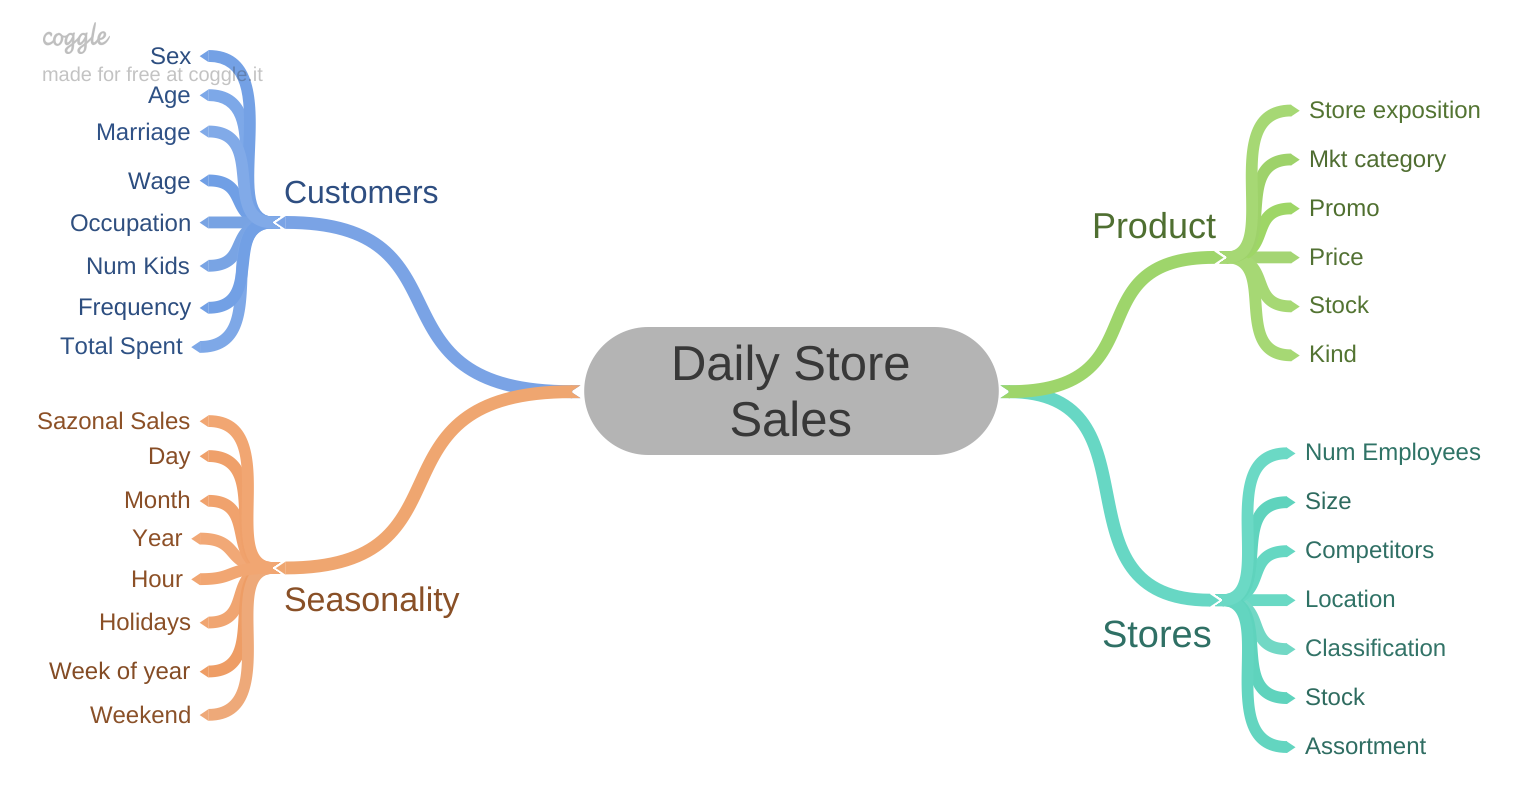

In [174]:
Image('C:\\Users\\marco\\OneDrive\\Documents\\repos\\ds_em_producao\\rossmann-sales-prediction\\img\\MindMapHyp.png',width = 800, height = 400)

### 2.1 Hypothesis brainstorming

#### 2.1.1 Hypothesis Stores

**1.** Stores with bigger staff are supposed to sell more 

**2.** Stores with bigger stocks are supposed too sell more 

**3.** Bigger stores are supposed too sell more

**4.** Stores with wider items assortment are supposed too sell more

**5.** Stores with nearer competitors are supposed too sell less

**6.** Stores with longer competition are supposed too sell more

#### 2.1.2 Hypotheis Products

**1.** Stores with products with more ads investment are supposed to sell more

**2.** Stores with products better exposed are supposed to sell more

**3.** Stores with lower products are supposed to sell more

**5.** Stores with agressive products promotions are supposed to sell more

**6.** Stores with longer products sales are supposed to sell more 

**7.** Stores with products under consecutives sales are supposed to sell more 

#### 2.1.3 Hypotheis Seasonality

**1.** Stores opened during Christmas Holiday are supposed to sell more.

**2.** Stores are supposed to sell more past the first years

**3.** Stores are supposed to sell more on 2nd semester 

**4.** Stores are supposed to sell more after 10th day on the month

**5.** Stores are supposed to sell less in the weekend 

**6.** Stores are supposed to sell less during scholar holidays 

### 2.2 Prioritized Hypothesis (are there data in this crisp cycle to evaluate it?)

**1.** Stores with wider items assortment are supposed too sell more

**2.** Stores with nearer competitors are supposed too sell less

**3.** Stores with longer competition are supposed too sell more

**4.** Stores with longer products sales are supposed to sell more 

**5.** Stores with products under consecutives sales are supposed to sell more 

**6.** Stores opened during Christmas Holiday are supposed to sell more.

**7.** Stores are supposed to sell more past the first years

**8.** Stores are supposed to sell more on 2nd semester 

**9.** Stores are supposed to sell more after 10th day on the month

**10.** Stores are supposed to sell less in the weekend 

**11.** Stores are supposed to sell less during scholar holidays 


In [175]:
df2 = df.copy()

### 2.3 Feature Engineering

In [176]:
#creating date features
#year
df2['year'] = df2['date'].dt.year

#day
df2['day'] = df2['date'].dt.day

#month
df2['month'] = df2['date'].dt.month

#week_of_year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#week-year
df2['year_week'] = df2['date'].dt.strftime("%Y-%W")

In [177]:
#competition_since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

In [178]:
#promo_since
df2['promo_since'] = df2['promo2_since_year'].astype(str)+'-'+df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')

In [179]:
#assortment => assortment level: a = basic, b = extra, c = extended
#df2['assortment'].unique()
df2['assortment'] = df2['assortment'].map({'a':'basic', 'b':'extra','c':'extended'})

In [180]:
#state_holday => a = public holiday, b = Easter holiday, c = Christmas, 0 = None
#df2['state_holiday'].unique()
df2['state_holiday'] = df2['state_holiday'].map({'a':'public', 'b':'easter','c':'christmas','0':'regular'})

## 3.0 Feature Filtering

In [181]:
#Feature Filtering => according to business constraints and data
#Feature Selection => most relevant feature to modeling
df3 = df2.copy()

### 3.1 Rows filtering

In [182]:
#open == 0 means store closed and we cant predict any sales
#sales == 0 means store didnt sell anything and we cant predict any sales
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)].reset_index(drop=True)

### 3.2 Attributes filtering

In [183]:
#customers is an attribute that must be predicted first (from another model) and used as input to predict sales (we dont have this prediction)
#open remained only open == 1, it's meaningless attribute
#promo_interval and month_map were manipulated onto new attributes
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop,axis=1)

## 4.0 Exploratory Data Analysis

### 4.1 Univariate Analysis

In [184]:
#How variables impact the event? How strong it is?
#EDA aims to gather business understanding, validate business hypothesis (triggered insights), understand best attribs to model
df4 = df3.copy()

#### 4.1.1 Response Variable

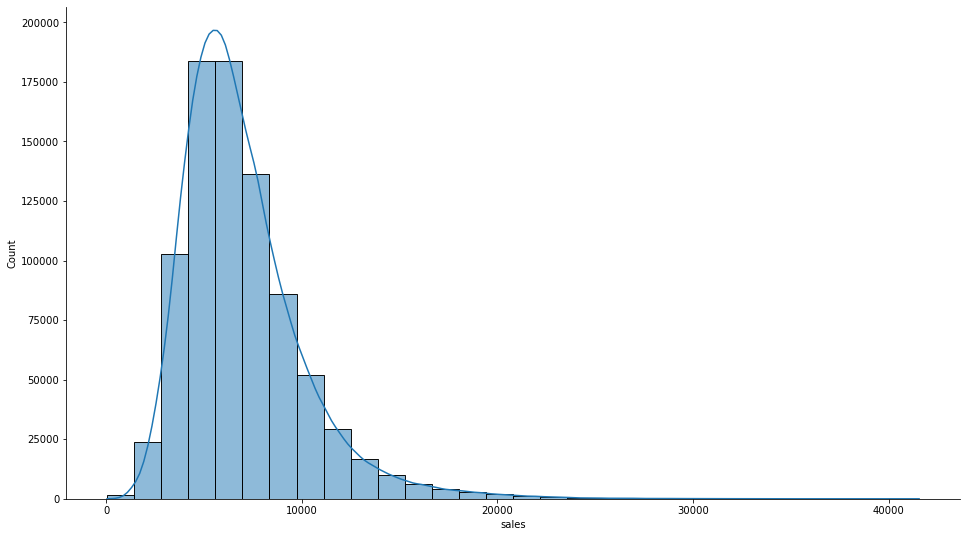

In [185]:
g = sns.displot(df4['sales'],bins=30,kde=True)
g.fig.set_size_inches(16,8)

#### 4.1.2 Numerical Variable

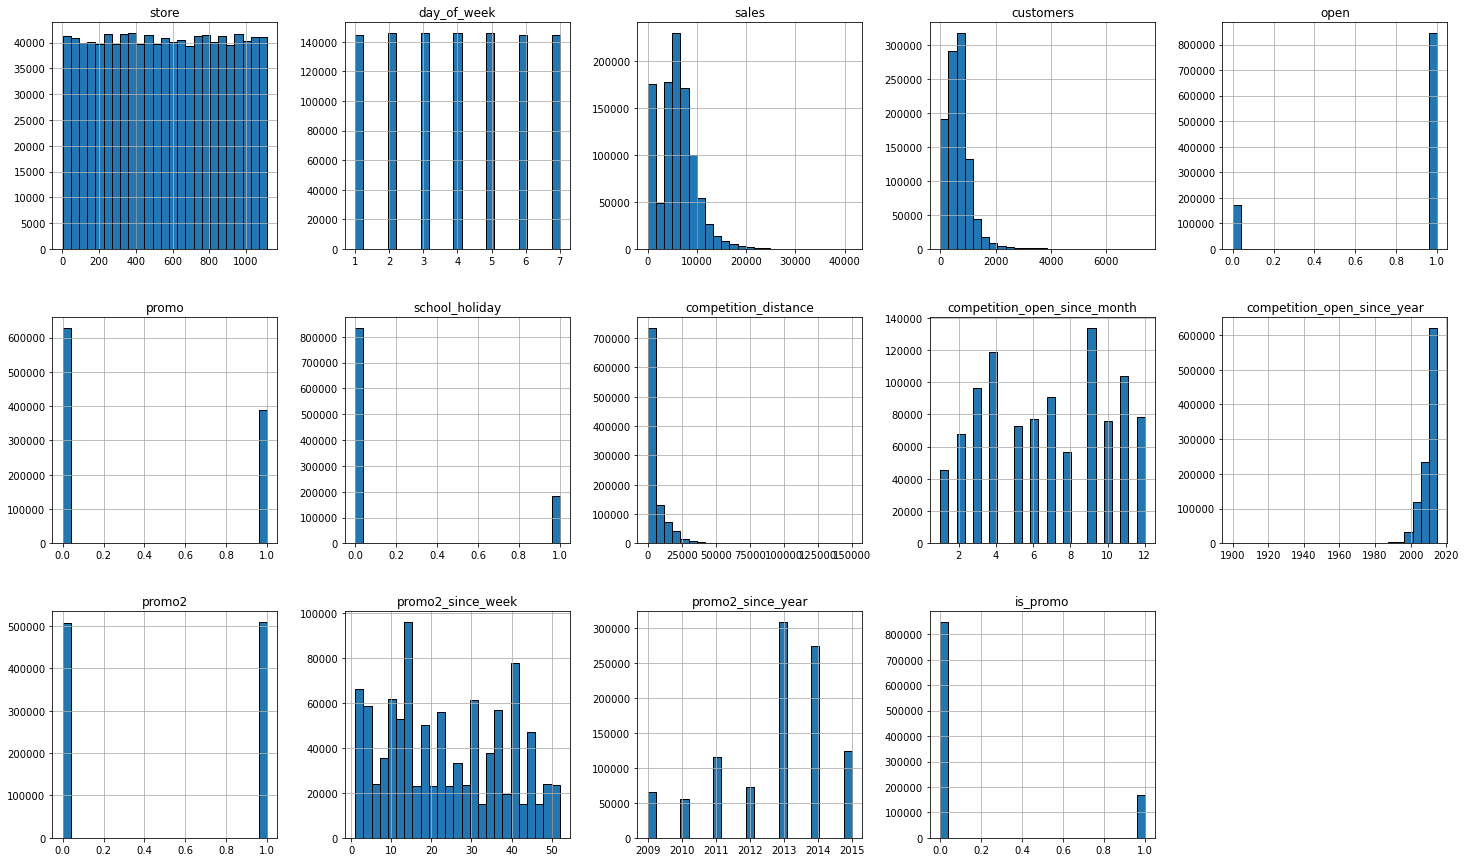

In [186]:
num_attr.hist(bins=25,figsize=(25,15),layout=(-1,5),edgecolor='black');

In [187]:
#sns.pairplot(num_attr,height=1.5,plot_kws={'s':2,'alpha':0.2})

#### 4.1.3 Categorical Variable

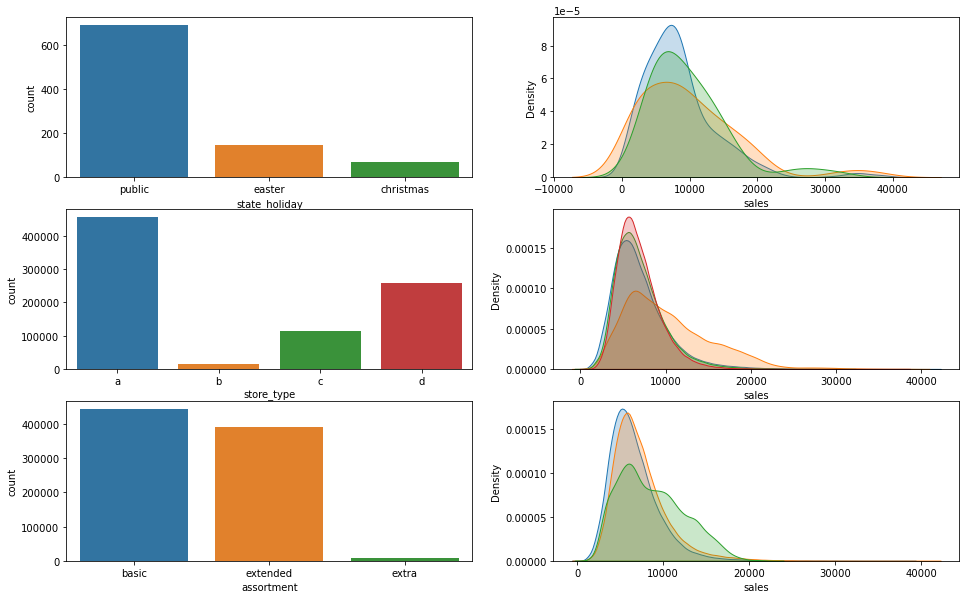

In [188]:
wo_regulardays = df4[df4['state_holiday']!='regular']

fig,ax=plt.subplots(figsize=(16,10))

plt.subplot(3,2,1)
sns.countplot(wo_regulardays['state_holiday']);

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public']['sales'],legend='public',shade=True);
sns.kdeplot(df4[df4['state_holiday']=='easter']['sales'],legend='easter',shade=True);
sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'],legend='christmas',shade=True);

plt.subplot(3,2,3)
sns.countplot(df4['store_type'],order=['a','b','c','d']);

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'],legend='a',shade=True);
sns.kdeplot(df4[df4['store_type']=='b']['sales'],legend='b',shade=True);
sns.kdeplot(df4[df4['store_type']=='c']['sales'],legend='c',shade=True);
sns.kdeplot(df4[df4['store_type']=='d']['sales'],legend='d',shade=True);

plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']=='basic']['sales'],legend='basic',shade=True);
sns.kdeplot(df4[df4['assortment']=='extended']['sales'],legend='extended',shade=True);
sns.kdeplot(df4[df4['assortment']=='extra']['sales'],legend='extra',shade=True);

### 4.2 Bivariate Analysis

In [189]:
#sns.pairplot(num_attr,height=3,plot_kws={'s':3,'alpha':0.2});

#### H1. Stores with wider items assortment are supposed too sell more
**FALSE** --> Stores with WIDER ITEMS ASSORTMENTS sell LESS -> INSIGHT, relevant to model 

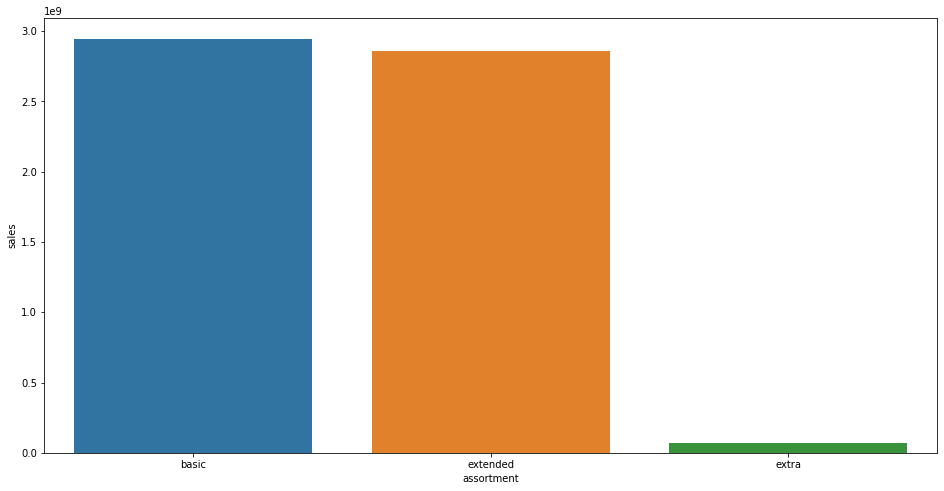

In [190]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
fig,ax=plt.subplots(figsize=(16,8))
sns.barplot(data=aux1, x='assortment', y='sales');

<AxesSubplot:xlabel='year_week'>

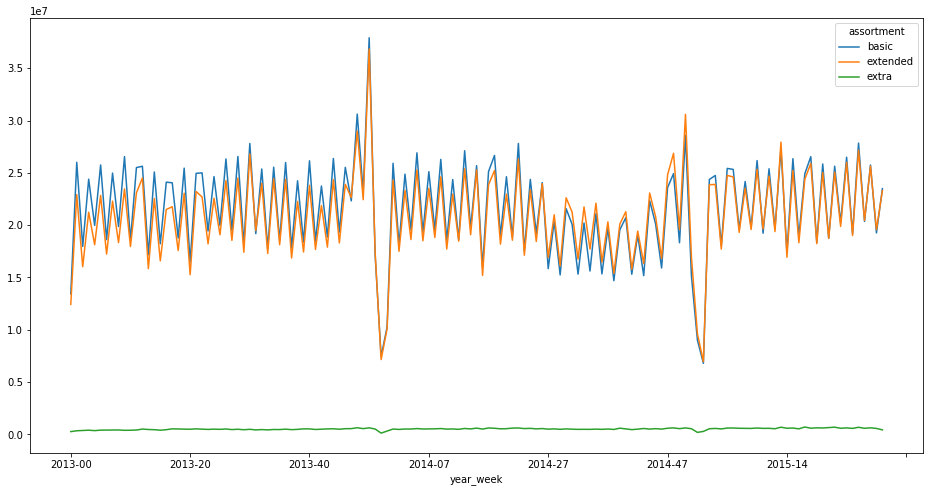

In [191]:
aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux3 = aux2.pivot(index='year_week', columns='assortment',values='sales')
aux3.plot(figsize=(16,8))

<AxesSubplot:xlabel='year_week'>

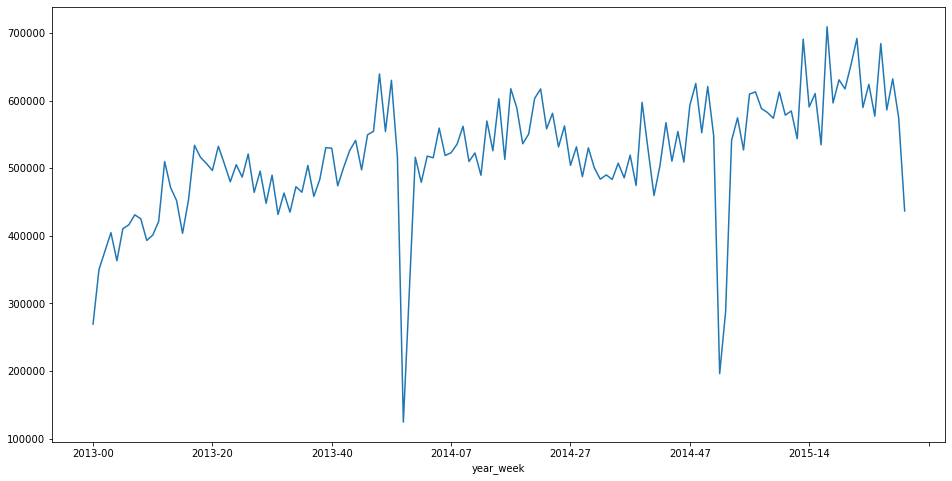

In [192]:
aux3['extra'].plot(figsize=(16,8))

#### H2. Stores with nearer competitors are supposed too sell less
**FALSE** --> Stores with NEARER COMPETITORES sell MORE -> INSIGHT, not too relevant to model

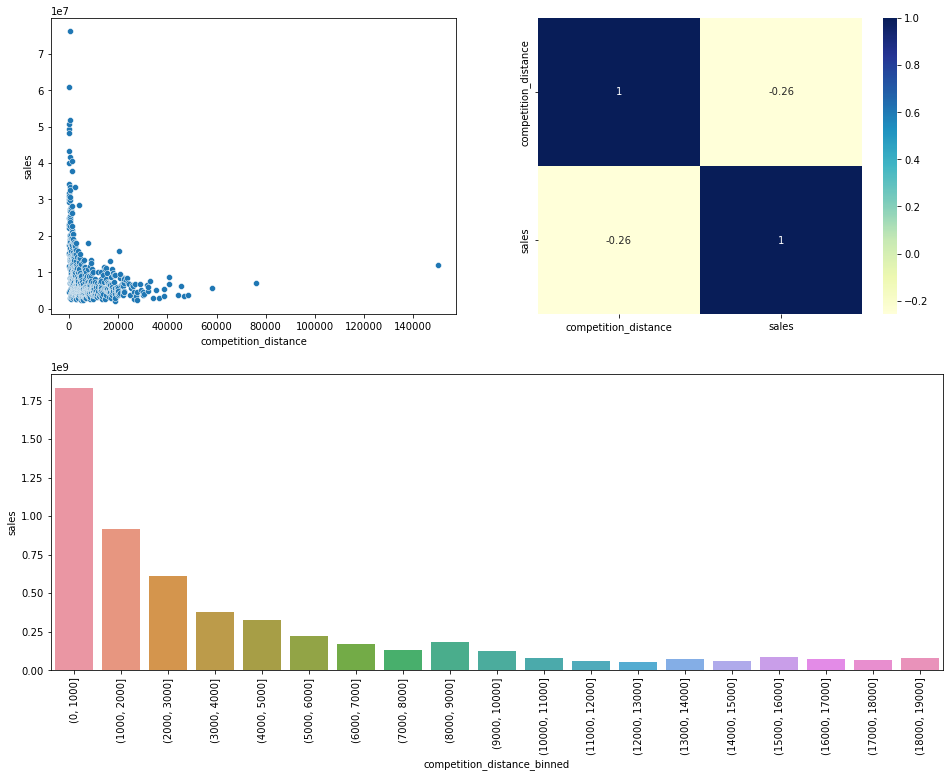

In [193]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index() 
fig, axes = plt.subplot_mosaic("AB;CC",figsize=(16,12))

sns.scatterplot(x='competition_distance',y='sales', data=aux1, ax=axes['A'])
sns.heatmap(aux1.corr(),annot=True,cmap='YlGnBu',ax=axes['B'])

bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned']= pd.cut(aux1['competition_distance'],bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
plt.xticks(rotation=90)
sns.barplot(x='competition_distance_binned',y='sales', data=aux2,ax=axes['C']);

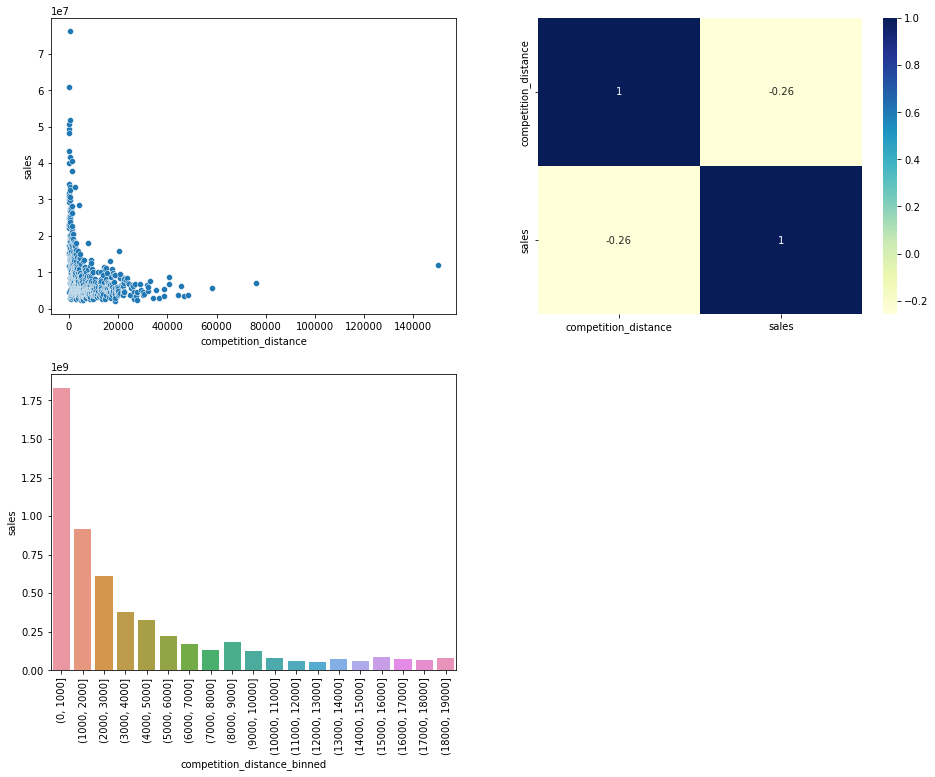

In [194]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplots(figsize=(16,12))

plt.subplot(2,2,1)
sns.scatterplot(x='competition_distance',y='sales', data=aux1)

plt.subplot(2,2,2)
sns.heatmap(aux1.corr(),annot=True,cmap='YlGnBu')

plt.subplot(2,2,3)

bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned']= pd.cut(aux1['competition_distance'],bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
plt.xticks(rotation=90)
sns.barplot(x='competition_distance_binned',y='sales', data=aux2);

#### H3. Stores with longer competition are supposed too sell more
**FALSE** --> Stores with LONGER competiton sell LESS -> INSIGHT

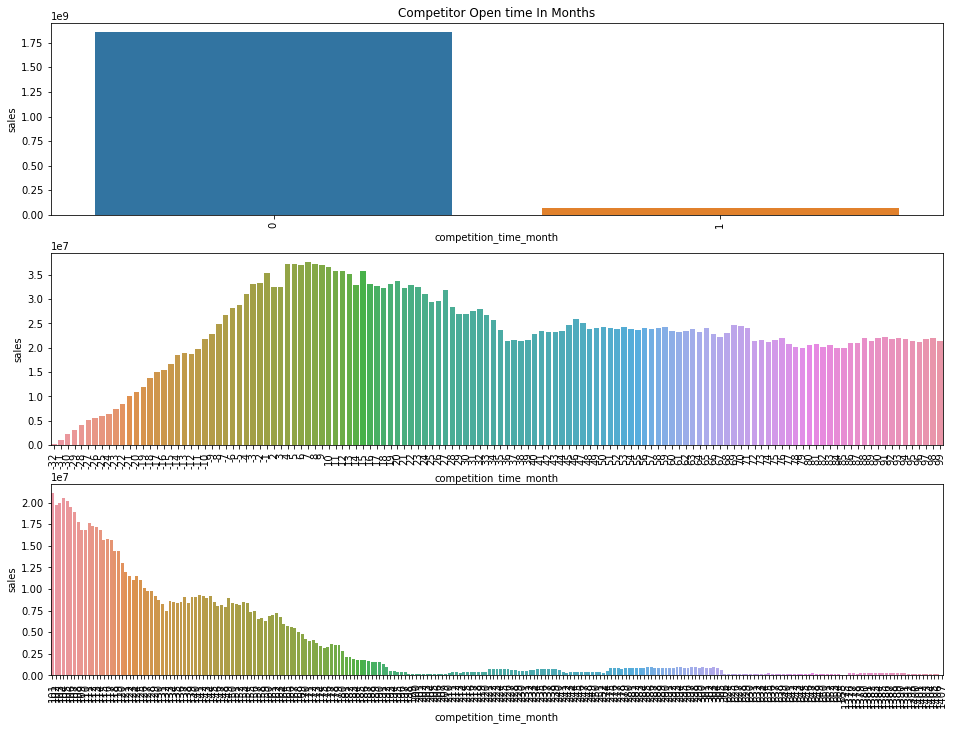

In [195]:
fig,ax = plt.subplot_mosaic("A;B;C",figsize=(16,12))

aux = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()

aux0 = aux[(aux['competition_time_month'] == 0)  | (aux['competition_time_month'] == 1)]
sns.barplot(x='competition_time_month',y='sales',data=aux0, ax=ax['A'])
ax['A'].set_title("Competitor Open time In Months")
ax['A'].tick_params(axis='x', rotation=90)


aux1 = aux[(aux['competition_time_month']  < 100) & (aux['competition_time_month'] != 0)  & (aux['competition_time_month'] != 1)] 
sns.barplot(x='competition_time_month',y='sales',data=aux1, ax=ax['B'])
ax['B'].tick_params(axis='x', rotation=90)


aux2 = aux[aux['competition_time_month'] > 100]
sns.barplot(x='competition_time_month',y='sales',data=aux2, ax=ax['C']);
ax['C'].tick_params(axis='x', rotation=90)


#### H4. Stores with longer products sales are supposed to sell more
**FALSE** Store with longer product sales, after a certain period, tend to sell less -> not too relevant to model

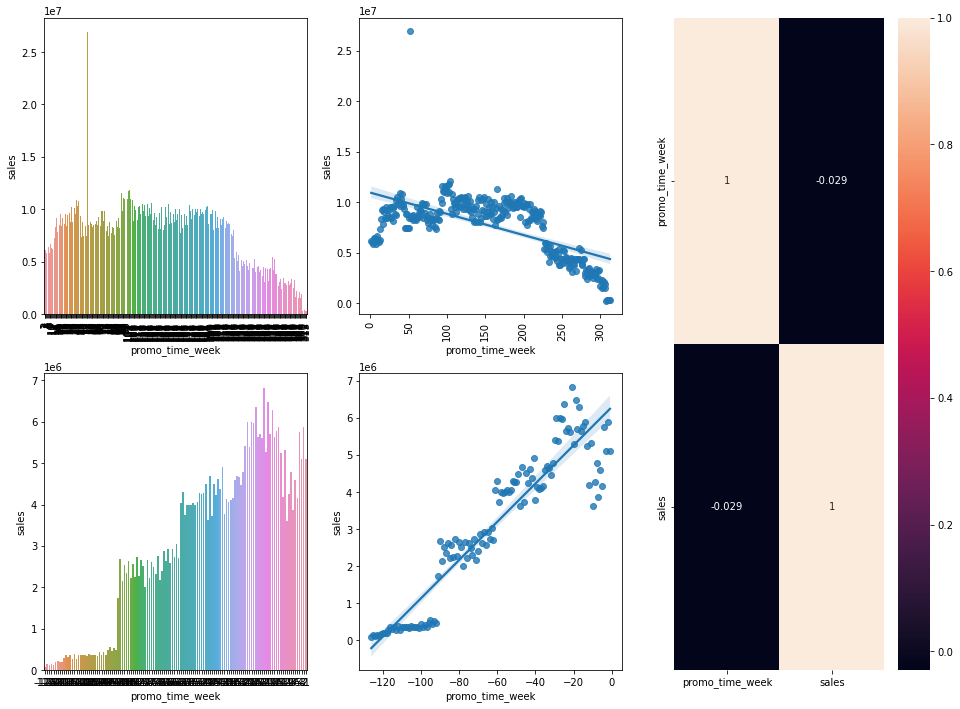

In [196]:
aux = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

fig,ax = plt.subplot_mosaic("ABC;DEC",figsize=(16,12))

promo_extendido = aux[aux['promo_time_week']>0]
promo_regular = aux[aux['promo_time_week']<0]

sns.barplot(data=promo_extendido,x='promo_time_week',y='sales',ax=ax['A']);
ax['A'].tick_params(axis='x', rotation=90)
sns.barplot(data=promo_regular,x='promo_time_week',y='sales',ax=ax['D']);
ax['B'].tick_params(axis='x', rotation=90)
sns.heatmap(aux.corr(method='pearson'),annot=True,ax=ax['C'])

sns.regplot(data=promo_extendido,x='promo_time_week',y='sales',ax=ax['B']);
sns.regplot(data=promo_regular,x='promo_time_week',y='sales',ax=ax['E']);


#### H5. Stores with products under consecutives sales are supposed to sell more
**FALSE** Stores with products under CONSECUTIVE SALES sell LESS -> INSIGHT, not too relevant to model


In [197]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index().sort_values(by='sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


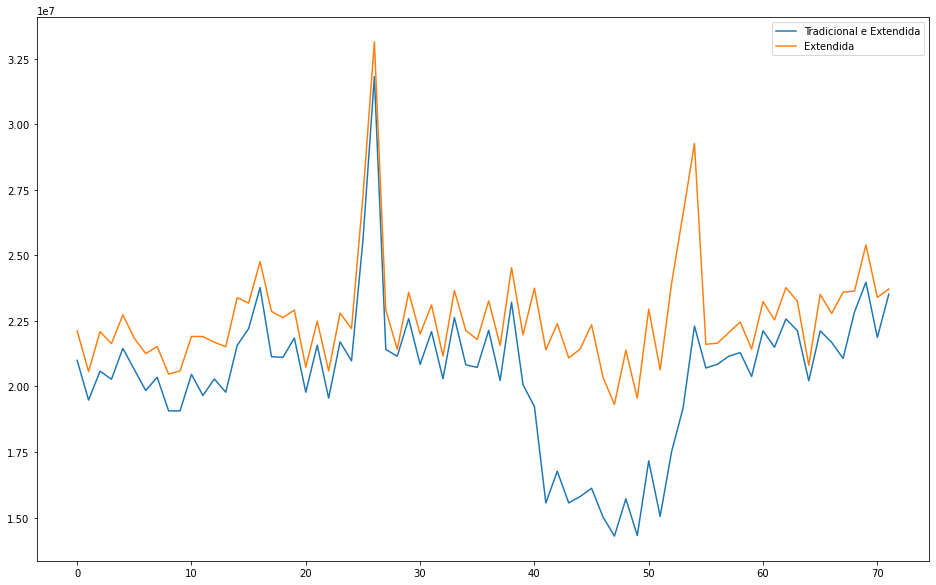

In [198]:
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(figsize=(16,10))

aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional e Extendida','Extendida'])

#### H6. Stores opened during Christmas Holiday are supposed to sell more than regular days.
**TRUE** Stores during Christmans have higher mean (not sum) sales than regular days -> NOT INSIGHT, but relevant to model

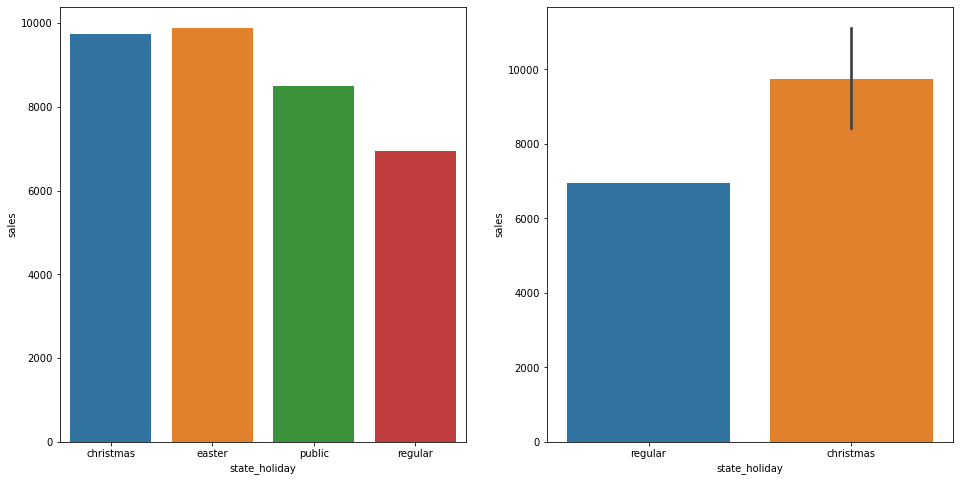

In [199]:
christmas_holi = (df4['state_holiday']=='christmas') | (df4['state_holiday']=='regular') 
aux = df4[['state_holiday','sales']].groupby('state_holiday').mean().reset_index()
fig, ax = plt.subplot_mosaic("AB",figsize=(16,8))
sns.barplot(data=aux,x='state_holiday',y='sales',ax=ax['A'])
sns.barplot(data=df4[christmas_holi],x='state_holiday',y='sales',ax=ax['B']);

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

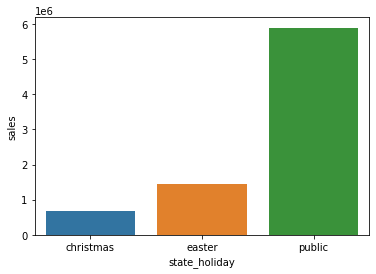

In [200]:
only_holidays = df4[df4['state_holiday']!='regular']
aux = only_holidays.groupby('state_holiday').sum().reset_index()
sns.barplot(data=aux,x='state_holiday', y='sales')

<AxesSubplot:xlabel='year', ylabel='sales'>

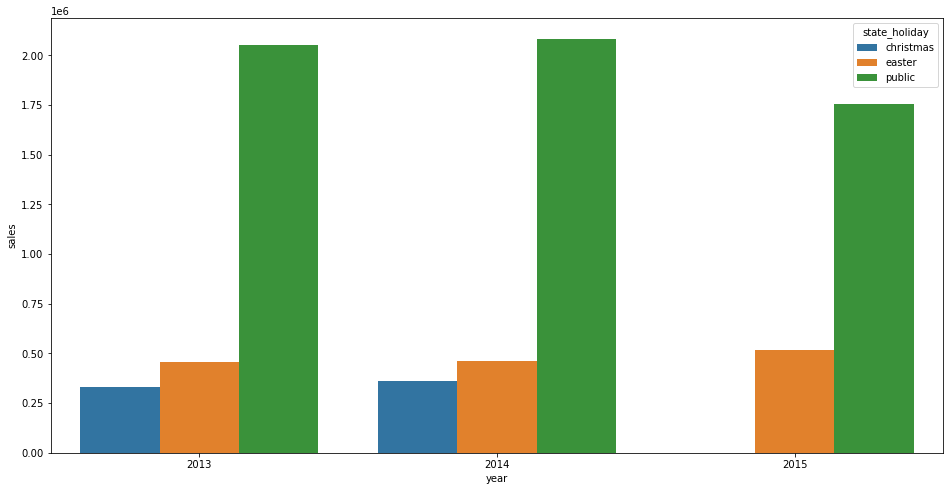

In [201]:
aux1 = only_holidays[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()

plt.subplots(figsize=(16,8))
sns.barplot(data=aux1, x='year',y='sales',hue='state_holiday')

#### H7.Stores are supposed to sell more past the first years
**FALSE** Stores sell LESS along the years -> NOT INSIGHT, but relevant to model

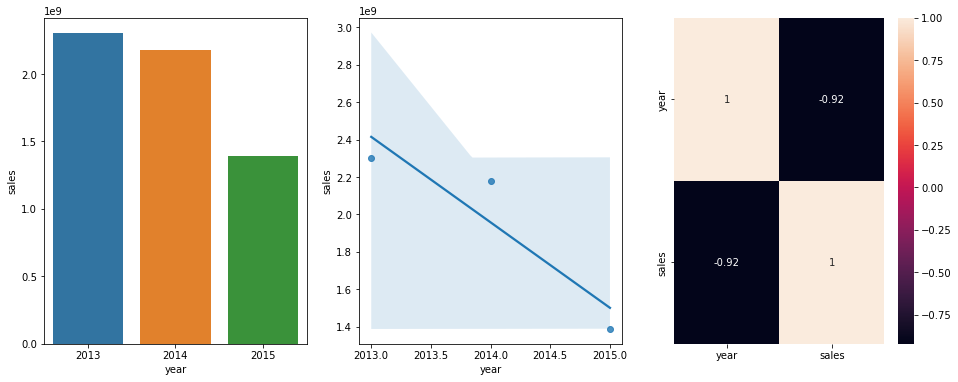

In [202]:
aux = df4[['year','sales']].groupby('year').sum().reset_index()

fig,ax = plt.subplot_mosaic("ABC",figsize=(16,6))
sns.barplot(data=aux, x='year', y='sales', ax=ax['A']);
sns.regplot(data=aux, x='year', y='sales', ax=ax['B']);
sns.heatmap(aux.corr(method='pearson'),annot=True, ax=ax['C']);

#### H8.Stores are supposed to sell more on 2nd semester 
**FALSE** Stores SELL LESS on 2nd semester -> NOT INSIGHT, but relevant to model

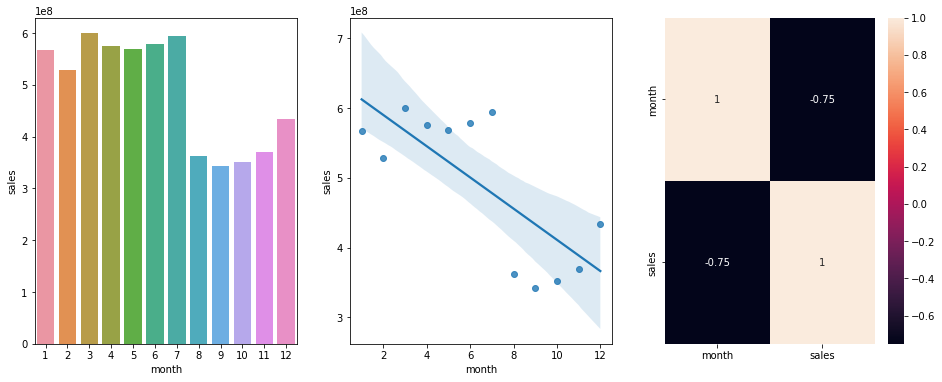

In [203]:
aux = df4[['month','sales']].groupby('month').sum().reset_index()

fig,ax = plt.subplot_mosaic("ABC",figsize=(16,6))
sns.barplot(data=aux, x='month', y='sales', ax=ax['A']);
sns.regplot(data=aux, x='month', y='sales', ax=ax['B']);
sns.heatmap(aux.corr(method='pearson'),annot=True, ax=ax['C']);

#### H9. Stores are supposed to sell more after 10th day on the month
**TRUE** -> NOT INSIGHT

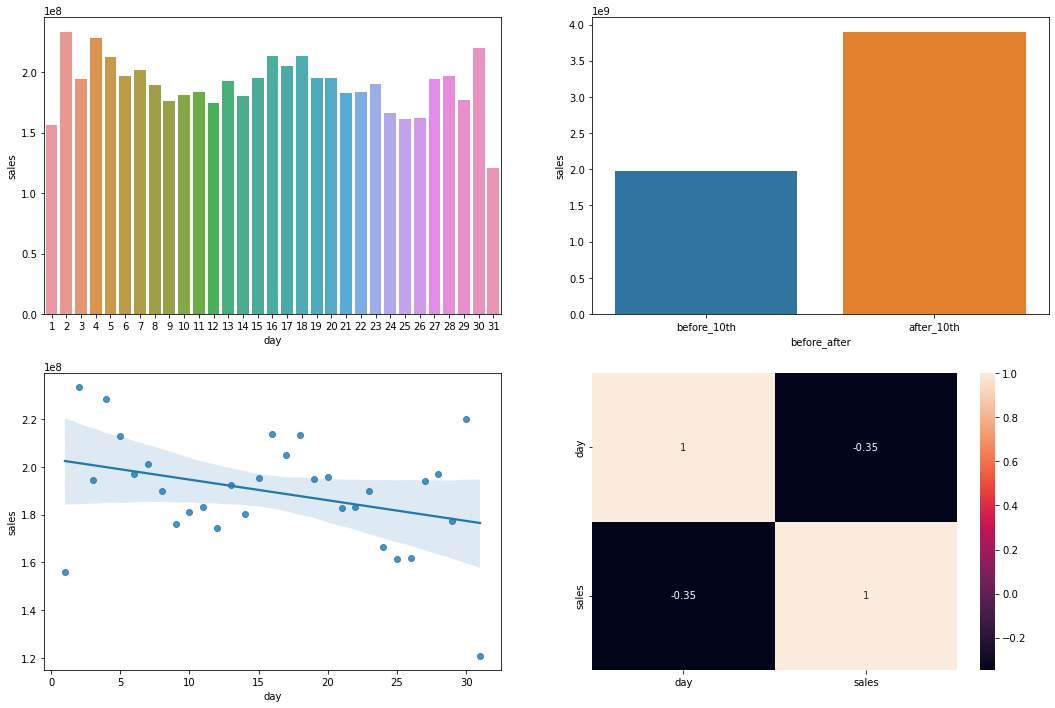

In [204]:
df4['before_after'] = df4['day'].apply(lambda x: 'before_10th' if x <=10 else 'after_10th')
aux1 = df4[['before_after','sales']].groupby('before_after').sum().reset_index()

aux2= df4[['day','sales']].groupby('day').sum().reset_index()

fig,ax = plt.subplot_mosaic("AB;CD",figsize=(18,12))
sns.barplot(data=aux2, x='day', y='sales', ax=ax['A']);
sns.regplot(data=aux2, x='day', y='sales', ax=ax['C']);
sns.heatmap(aux2.corr(method='pearson'),annot=True, ax=ax['D'])
sns.barplot(data=aux1,x='before_after',y='sales', order=['before_10th','after_10th'],ax=ax['B']);

#### H10. Stores are supposed to sell less in the weekend 
**TRUE** -> NOT INSIGHT, but relevant to model

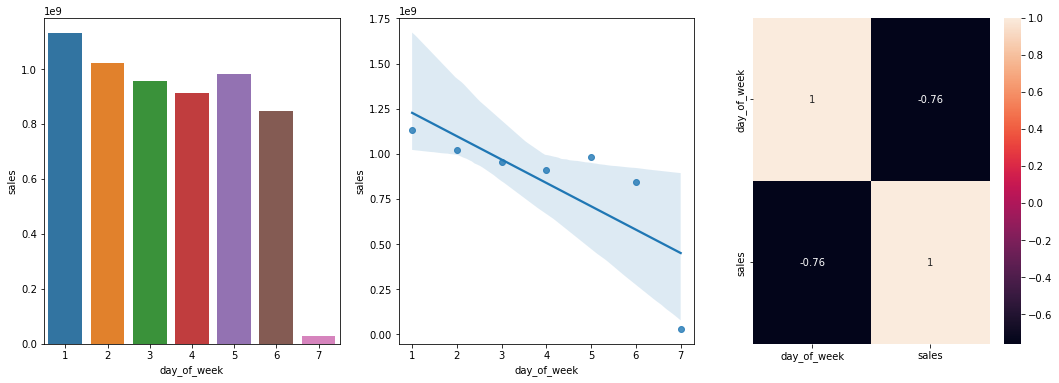

In [205]:
aux2= df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

fig,ax = plt.subplot_mosaic("ABC",figsize=(18,6))
sns.barplot(data=aux2, x='day_of_week', y='sales', ax=ax['A'])
sns.regplot(data=aux2, x='day_of_week', y='sales', ax=ax['B'])
sns.heatmap(aux2.corr(method='pearson'),annot=True, ax=ax['C']);

#### H11. Stores are supposed to sell less during scholar holidays
**TRUE** Except during vacations -> NOT INSIGHT

<AxesSubplot:label='B', xlabel='month', ylabel='sales'>

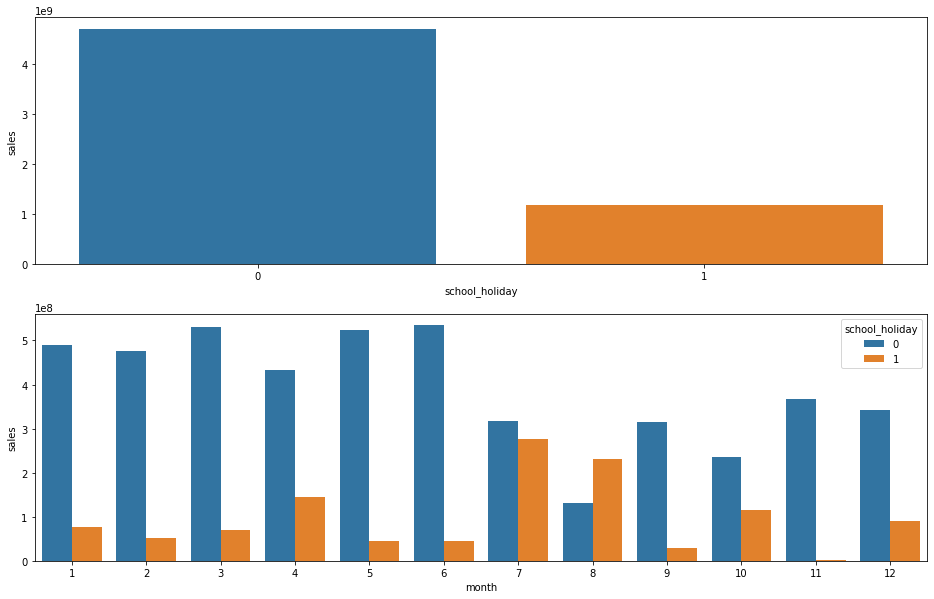

In [206]:
aux1= df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()

fig,ax = plt.subplot_mosaic("A;B",figsize=(16,10))
sns.barplot(data=aux1, x='school_holiday', y='sales', ax=ax['A'])
sns.barplot(data=aux2, x='month', y='sales', hue='school_holiday', ax=ax['B'])

### 4.3 Multivariate Analysis

#### 4.1.1 Numerical Attributes

In [207]:
num_attr = df4.select_dtypes(include=['int64','float'])
num_attr

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,day,month,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.00,9,2008,0,31,2015,0,2015,31,7,84,0
1,2,5,6064,1,1,570.00,11,2007,1,13,2010,1,2015,31,7,94,279
2,3,5,8314,1,1,14130.00,12,2006,1,14,2011,1,2015,31,7,105,226
3,4,5,13995,1,1,620.00,9,2009,0,31,2015,0,2015,31,7,71,0
4,5,5,4822,1,1,29910.00,4,2015,0,31,2015,0,2015,31,7,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,682,2,3375,0,1,150.00,9,2006,0,1,2013,0,2013,1,1,77,0
844334,733,2,10765,0,1,860.00,10,1999,0,1,2013,0,2013,1,1,161,0
844335,769,2,5035,0,1,840.00,1,2013,1,48,2012,1,2013,1,1,0,6
844336,948,2,4491,0,1,1430.00,1,2013,0,1,2013,0,2013,1,1,0,0


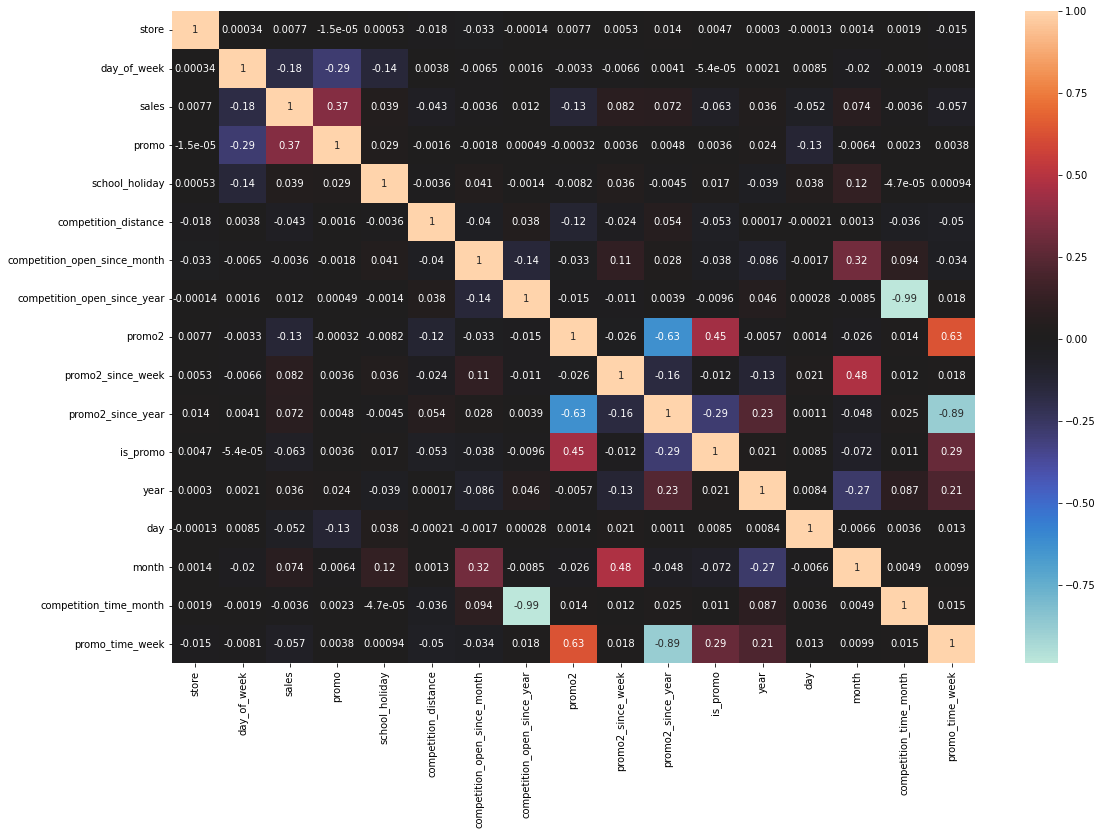

In [208]:
plt.subplots(figsize=(18,12))
sns.heatmap(num_attr.corr(method='pearson'),annot=True,cmap='icefire');

#### 4.1.2 Categorical Attributes

In [209]:
cat_attrib = df4.select_dtypes(include=['object'])

a1 = cramer_v(cat_attrib['state_holiday'],cat_attrib['state_holiday'])
a2 = cramer_v(cat_attrib['state_holiday'],cat_attrib['store_type'])
a3 = cramer_v(cat_attrib['state_holiday'],cat_attrib['assortment'])

a4 = cramer_v(cat_attrib['store_type'],cat_attrib['state_holiday'])
a5 = cramer_v(cat_attrib['store_type'],cat_attrib['store_type'])
a6 = cramer_v(cat_attrib['store_type'],cat_attrib['assortment'])

a7 = cramer_v(cat_attrib['assortment'],cat_attrib['state_holiday'])
a8 = cramer_v(cat_attrib['assortment'],cat_attrib['store_type'])
a9 = cramer_v(cat_attrib['assortment'],cat_attrib['assortment'])

cramer_v_table = pd.DataFrame({'state_holiday':[a1,a2,a3],
                              'store_type': [a4,a5,a6],
                              'assortment':[a7,a8,a9]})

cramer_v_table = cramer_v_table.set_index(cramer_v_table.columns)

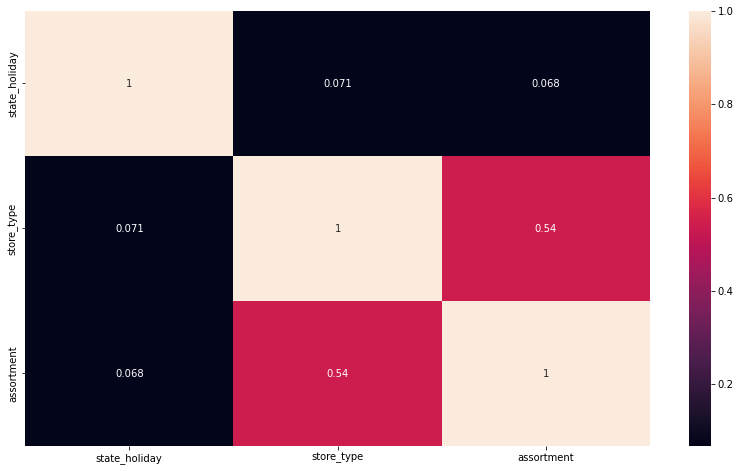

In [210]:
plt.subplots(figsize=(14,8))
sns.heatmap(cramer_v_table,annot=True);

## 5.0 Data Preparation

In [211]:
df5 = df4.copy()

In [212]:
#date limit to split => we want to predict 6 week forward,thus we separate the last 6 week from dataset to test
df5[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [213]:
#training dataset
X_train = df5[df5['date'] < '2015-06-19']
y_train = X_train['sales']

#testing dataset

X_test = df5[df5['date']>= '2015-06-19'] 
y_test = X_test['sales']


print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))
print('\nTesting Min Date: {}'.format(X_test['date'].min()))
print('Testing Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Testing Min Date: 2015-06-19 00:00:00
Testing Max Date: 2015-07-31 00:00:00


### 5.1 Normalization

In [62]:
#identify normal distributed attributes and apply normalization=> None in this dataset

### 5.2 Rescaling

In [214]:
rs = RobustScaler()
mms = MinMaxScaler()

In [215]:
# competition_distance
X_train['competition_distance'] = rs.fit_transform(X_train[['competition_distance']].values)
X_test['competition_distance'] = rs.transform(X_test[['competition_distance']].values)

pickle.dump(rs, open('C:\\Users\\marco\\OneDrive\\Documents\\repos\\ds_em_producao\\rossmann-sales-prediction\\local\\parameters\\competition_distance_scaler.pkl','wb'))

In [216]:
# competition_time_month
X_train['competition_time_month'] = rs.fit_transform(X_train[['competition_time_month']].values)
X_test['competition_time_month'] = rs.transform(X_test[['competition_time_month']].values)

pickle.dump(rs, open('C:\\Users\\marco\\OneDrive\\Documents\\repos\\ds_em_producao\\rossmann-sales-prediction\\local\\parameters\\competition_time_month_scaler.pkl','wb'))

In [217]:
#promo_time_week
X_train['promo_time_week'] = mms.fit_transform(X_train[['promo_time_week']].values)
X_test['promo_time_week'] = mms.transform(X_test[['promo_time_week']].values)

pickle.dump(mms, open('C:\\Users\\marco\\OneDrive\\Documents\\repos\\ds_em_producao\\rossmann-sales-prediction\\local\\parameters\\promo_time_week_scaler.pkl','wb'))

In [218]:
#year
X_train['year'] = rs.fit_transform(X_train[['year']].values)
X_test['year'] = rs.transform(X_test[['year']].values)

df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('C:\\Users\\marco\\OneDrive\\Documents\\repos\\ds_em_producao\\rossmann-sales-prediction\\local\\parameters\\year_scaler.pkl','wb'))

### 5.3 Transformation

#### 5.3.1 Encoding

In [219]:
#state_holiday => its a 'status' condition, fits with One Hot Encoding
X_train = pd.get_dummies(X_train,prefix=['state_holiday'],columns=['state_holiday'])
X_test = pd.get_dummies(X_test,prefix=['state_holiday'],columns=['state_holiday'])

#store_type => its a type, fits with Label Enconding
le = LabelEncoder()

X_train['store_type'] = le.fit_transform(X_train['store_type'])
X_test['store_type'] = le.transform(X_test['store_type'])

pickle.dump(le, open('C:\\Users\\marco\\OneDrive\\Documents\\repos\\ds_em_producao\\rossmann-sales-prediction\\local\\parameters\\store_type_encoder.pkl','wb'))

#assortment => there is a order dependency, we can label as ordinal, fits with Ordinal Enconding
label_enconding_map = {'basic':1, 'extra':2, 'extended':3}
X_train['assortment'] = X_train['assortment'].map(label_enconding_map)
X_test['assortment'] = X_test['assortment'].map(label_enconding_map)

#### 5.3.2 Response Variable Transformation

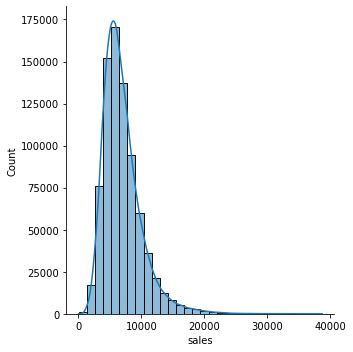

In [220]:
sns.displot(y_train,bins=30,kde=True)

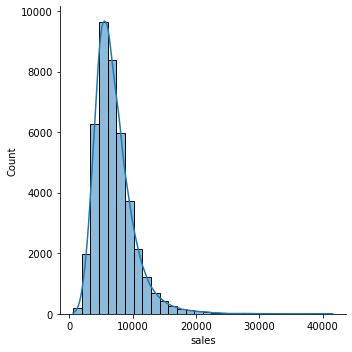

In [221]:
sns.displot(y_test,bins=30,kde=True)

In [222]:
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

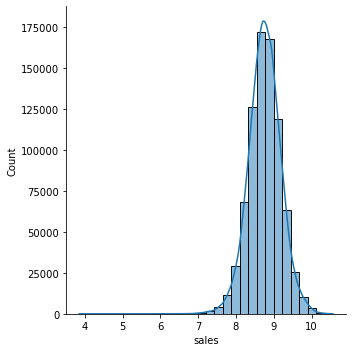

In [223]:
sns.displot(y_train,bins=30,kde=True)

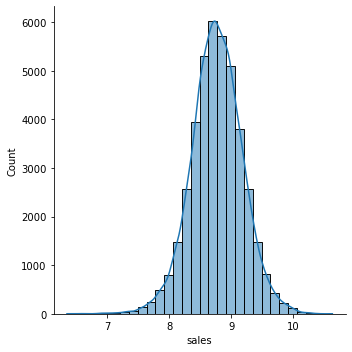

In [224]:
sns.displot(y_test,bins=30,kde=True)

#### 5.3.3 Nature Transformation

In [225]:
#temporal variables have cyclical behavior thus must show it to model => use trigonometry to derive new attributes
# REFACTOR!!

#day_of_week
X_train['day_of_week_sin'] = X_train['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))
X_train['day_of_week_cos'] = X_train['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))

X_test['day_of_week_sin'] = X_test['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))
X_test['day_of_week_cos'] = X_test['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))

#month
X_train['month_sin'] = X_train['month'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
X_train['month_cos'] = X_train['month'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

X_test['month_sin'] = X_test['month'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
X_test['month_cos'] = X_test['month'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

#day
X_train['day_sin'] = X_train['day'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
X_train['day_cos'] = X_train['day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))

X_test['day_sin'] = X_test['day'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
X_test['day_cos'] = X_test['day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))

#week of year
X_train['week_of_year_sin'] = X_train['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi / 52)))
X_train['week_of_year_cos'] = X_train['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi / 52)))

X_test['week_of_year_sin'] = X_test['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi / 52)))
X_test['week_of_year_cos'] = X_test['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi / 52)))


## 6.0 Feature Selection => Occam's Razor

In [226]:
# Dropping Derivated features
cols_drop = ['week_of_year','day','before_after','month','day_of_week','year_week','promo_since','competition_since']

X_train = X_train.drop(cols_drop, axis=1)
X_test = X_test.drop(cols_drop, axis=1)

### 6.2 Boruta as Feature Selector

In [76]:
# #vectorize x_train and y_train
# X_train_n = X_train.drop(['date','sales'],axis=1).values
# y_train_n = y_train.values.ravel()

# # #define RandomForest
# rf = RandomForestRegressor(n_jobs=-1)

# # #define boruta
# boruta = BorutaPy(rf, n_estimators='auto',verbose=2, random_state=42).fit(X_train_n,y_train_n)

#### 6.2.1 Best Features from Boruta

In [77]:
# cols_selected = boruta.support_.tolist()

# #best features
# X_train_fs = X_train.drop(['date','sales'],axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# #not selected features
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))
# cols_not_selected_boruta

#### 6.2.2 Manual Feature Selection - after running 1x Boruta

In [227]:
cols_not_selected_boruta = ['is_promo',
                             'school_holiday',
                             'state_holiday_christmas',
                             'state_holiday_easter',
                             'state_holiday_public',
                             'state_holiday_regular',
                             'year']

cols_selected_boruta = ['store',
                         'promo',
                         'store_type',
                         'assortment',
                         'competition_distance',
                         'competition_open_since_month',
                         'competition_open_since_year',
                         'promo2',
                         'promo2_since_week',
                         'promo2_since_year',
                         'competition_time_month',
                         'promo_time_week',
                         'day_of_week_sin',
                         'day_of_week_cos',
                         'month_sin',
                         'month_cos',
                         'day_sin',
                         'day_cos',
                         'week_of_year_sin',
                         'week_of_year_cos']

#full dataset that will be splitted on cv function later
feat_to_add = ['date','sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

## 7.0 Machine Learning Modeling

In [228]:
#to single performance - already splited
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

In [229]:
#to cross validation - full dataset
xtraining = X_train[cols_selected_boruta_full]
xtraining['sales'] = np.log1p(xtraining['sales'])

### 7.1 Average Model

In [230]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#predictions => we assumed the simplest model (mean) as prediction to set as baseline
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left',on='store')

yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1 (yhat_baseline))
baseline_result

,Model,MAE,MAPE,RMSE,MPE
0,Average Model,1354.80,0.21,1835.14,-0.03


### 7.2 Linear Regression Model

In [231]:
#model
lr = LinearRegression().fit(x_train,y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model,MAE,MAPE,RMSE,MPE
0,Linear Regression,1868.42,0.29,2671.00,-0.08


In [232]:
#linear cross validation
lr_result_cv = cross_validation('Linear Regression',LinearRegression(), xtraining,5, verbose=True)


Linear RegressionK-fold number: 5
               Model     MAE  MAPE    RMSE  MPE
0  Linear Regression 2647.17  0.31 3821.23 0.05

Linear RegressionK-fold number: 4
               Model     MAE  MAPE    RMSE   MPE
0  Linear Regression 1908.92  0.33 2575.39 -0.18

Linear RegressionK-fold number: 3
               Model     MAE  MAPE    RMSE   MPE
0  Linear Regression 1803.80  0.30 2521.11 -0.11

Linear RegressionK-fold number: 2
               Model     MAE  MAPE    RMSE   MPE
0  Linear Regression 2069.32  0.29 2999.93 -0.03

Linear RegressionK-fold number: 1
               Model     MAE  MAPE    RMSE   MPE
0  Linear Regression 1980.33  0.28 2838.69 -0.03


### 7.3 Linear Regression Regularized Model - Lasso

In [233]:
#model
lrr = Lasso(alpha = 0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression Regularized', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model,MAE,MAPE,RMSE,MPE
0,Linear Regression Regularized,1892.35,0.29,2744.36,-0.06


In [234]:
#lasso cross validation
lrr_result_cv = cross_validation('Linear Reg Regularized - Lasso',Lasso(alpha=0.01),xtraining,5)

### 7.4 Random Forest Regressor 

In [235]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model,MAE,MAPE,RMSE,MPE
0,Random Forest Regressor,679.53,0.10,1011.03,-0.02


In [236]:
#random forest regressor cross validation
rf_result_cv = cross_validation('Random Forest Regressor',RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=42),xtraining,5)

### 7.5 XGBoost Regressor

In [237]:
#model
xgb_model = xgb.XGBRegressor().fit(x_train, y_train)

#prediction
yhat_xgb = xgb_model.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model,MAE,MAPE,RMSE,MPE
0,XGBoost Regressor,868.96,0.13,1238.55,-0.02


In [238]:
#xgboost regressor cross validation
xgb_result_cv = cross_validation('XGBoost Regressor',xgb.XGBRegressor(),xtraining,5)

### 7.6 Comparing Model's Performance

#### 7.6.1 Comparing  Single Performance

In [240]:
modeling_result = pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result]).sort_values('RMSE').reset_index(drop=True)
modeling_result

,Model,MAE,MAPE,RMSE,MPE
0,Random Forest Regressor,679.53,0.10,1011.03,-0.02
1,XGBoost Regressor,868.96,0.13,1238.55,-0.02
2,Average Model,1354.80,0.21,1835.14,-0.03
3,Linear Regression,1868.42,0.29,2671.00,-0.08
4,Linear Regression Regularized,1892.35,0.29,2744.36,-0.06


#### 7.6.2 Comparing Real Performance - Cross Validation

In [241]:
cross_validation_result = pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,xgb_result_cv]).sort_values('RMSE CV').reset_index(drop=True)
cross_validation_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.6 +/- 217.12,0.12 +/- 0.02,1254.29 +/- 316.21
1,XGBoost Regressor,1064.95 +/- 178.65,0.15 +/- 0.02,1519.92 +/- 242.12
2,Linear Regression,2081.91 +/- 295.72,0.3 +/- 0.02,2951.27 +/- 468.66
3,Linear Reg Regularized - Lasso,2116.39 +/- 341.57,0.29 +/- 0.01,3057.06 +/- 504.39


## 8.0 Hyperparameter Fine Tunning

### 8.1 Random Search

In [160]:
param = {'n_estimators':[1500, 1700, 2500, 3000, 3500],
         'eta':[0.01, 0.03],
         'max_depth':[3, 5, 9],
         'subsample':[0.1, 0.5, 0.7],
         'colsample_bytree':[0.3, 0.7, 0.9],
         'min_child_weight':[3, 8, 15]
}

MAX_EVAL = 5

In [123]:
#final_result = pd.DataFrame()

# for i in range(MAX_EVAL):

#     #hyperparameter tunning - random search
#     hp = {k : random.sample(v,1)[0] for k,v in param.items()}
    
#     print('Search {} - Hyperparameters '.format(i), hp)

#     #model
#     xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'],
#                                  eta=hp['eta'],
#                                  max_depth=hp['max_depth'],
#                                  subsample=hp['subsample'],
#                                  colsample_bytree=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'])


#     #performance
#     result  = cross_validation('XGBoost Regressor', xgb_model , xtraining, 5,verbose=False)
#     final_result = pd.concat([final_result,result])
#     final_result    

### 8.3 Final Model

In [242]:
#hyperparameters tuned
#param_tuned = { 'n_estimators': 3000,
#                'eta': 0.03,
#                'max_depth': 5,
#                'subsample': 0.7,
#                'colsample_bytree': 0.7,
#                'min_child_weight': 3
#}

#model
#xgb_model_tuned = xgb.XGBRegressor(objective='reg:squarederror',
#                                   n_estimators=param_tuned['n_estimators'],
#                                   eta=param_tuned['eta'],
#                                   max_depth=param_tuned['max_depth'],
#                                   subsample=param_tuned['subsample'],
#                                   colsample_bytree=param_tuned['colsample_bytree'],
#                                   min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

#prediction
#yhat_xgb_tuned = xgb_model_tuned.predict(x_test)

#performance
#xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
#xgb_result_tuned

#saving model
#pickle.dump(xgb_model_tuned, open('C:\\Users\\marco\\OneDrive\\Documents\\repos\\ds_em_producao\\rossmann-sales-prediction\\local\\model\\model_rossmann.pkl','wb'))

In [243]:
#loading model
pickled_model = pickle.load(open('C:\\Users\\marco\\OneDrive\\Documents\\repos\\ds_em_producao\\rossmann-sales-prediction\\local\\model\\model_rossmann.pkl', 'rb'))

#prediction
yhat_xgb_tuned = pickled_model.predict(x_test)

#performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model,MAE,MAPE,RMSE,MPE
0,XGBoost Regressor,829.84,0.12,1188.85,-0.00


## 9.0 Translating Performance Model into Business Performance

In [244]:
df7 = X_test[cols_selected_boruta].copy()
df7['sales'] = y_test.copy()
df7['date'] = X_test['date'].copy()

#rescaling back
df7['sales'] = np.expm1(df7['sales'])
df7['predictions'] = np.expm1(yhat_xgb_tuned)

### 9.1 Business Performance

In [245]:
#sum of predictions
df71 = df7[['store','sales','predictions']].groupby('store').sum().reset_index()

#MAE and MAPE
df71['MAE'] = df71.apply(lambda x: mean_absolute_error([x['sales']],[x['predictions']]),axis=1)
df71['MAPE'] = df71.apply(lambda x: mean_absolute_percentage_error([x['sales']],[x['predictions']]),axis=1)

#scenarios
df71['worst_scenario'] = df71['predictions'] - df71['MAE']
df71['best_scenario'] = df71['predictions'] + df71['MAE']

df71 = df71.drop(columns=['sales'])
df71 = df71[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

In [130]:
df71.sample(10)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
1078,1079,320551.31,312138.00,328964.62,8413.31,0.03
843,844,152892.38,148528.00,157256.75,4364.38,0.03
846,847,252607.09,243826.00,261388.19,8781.09,0.04
557,558,122020.68,120910.36,123131.00,1110.32,0.01
146,147,312720.12,299000.00,326440.25,13720.13,0.05
677,678,261349.62,247954.25,274745.00,13395.38,0.05
453,454,211446.44,204878.88,218014.00,6567.56,0.03
742,743,150260.97,141698.00,158823.94,8562.97,0.06
31,32,151692.70,143992.41,159393.00,7700.30,0.05
981,982,296373.50,286862.00,305885.00,9511.50,0.03


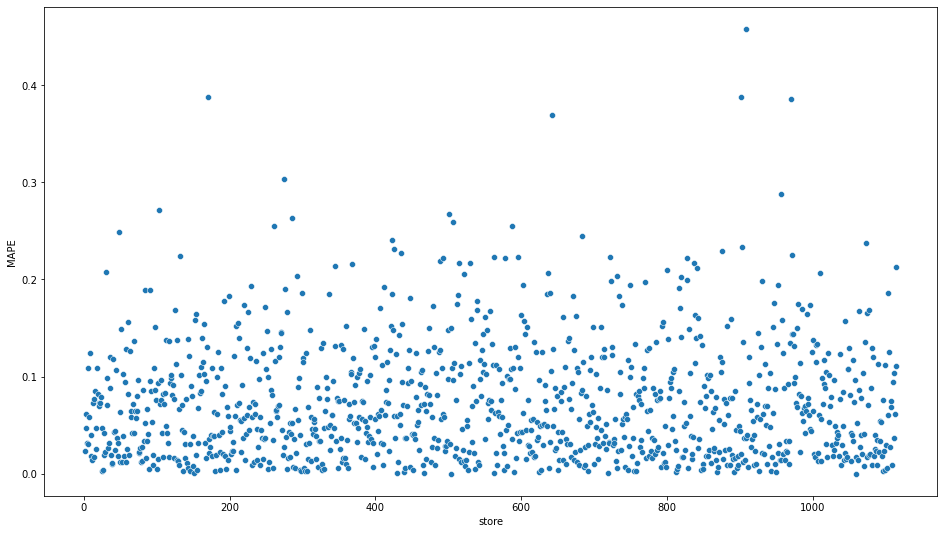

In [246]:
plt.subplots(figsize=(16,9))
sns.scatterplot(data=df71, x='store',y='MAPE');

### 9.2 Total Performance

In [247]:
total_best = np.sum(df71['best_scenario']) / 1000000
total_worst = np.sum(df71['worst_scenario']) / 1000000
total_pred = np.sum(df71['predictions']) / 1000000

summary = pd.DataFrame({'Best scenario (M)':total_best , 'Worst Scenario (M)':total_worst, 'Total Predictions (M)':total_pred},index=[0])
summary

,Best scenario (M),Worst Scenario (M),Total Predictions (M)
0,303.00,259.99,281.50


### 9.3 Machine Learning Performance

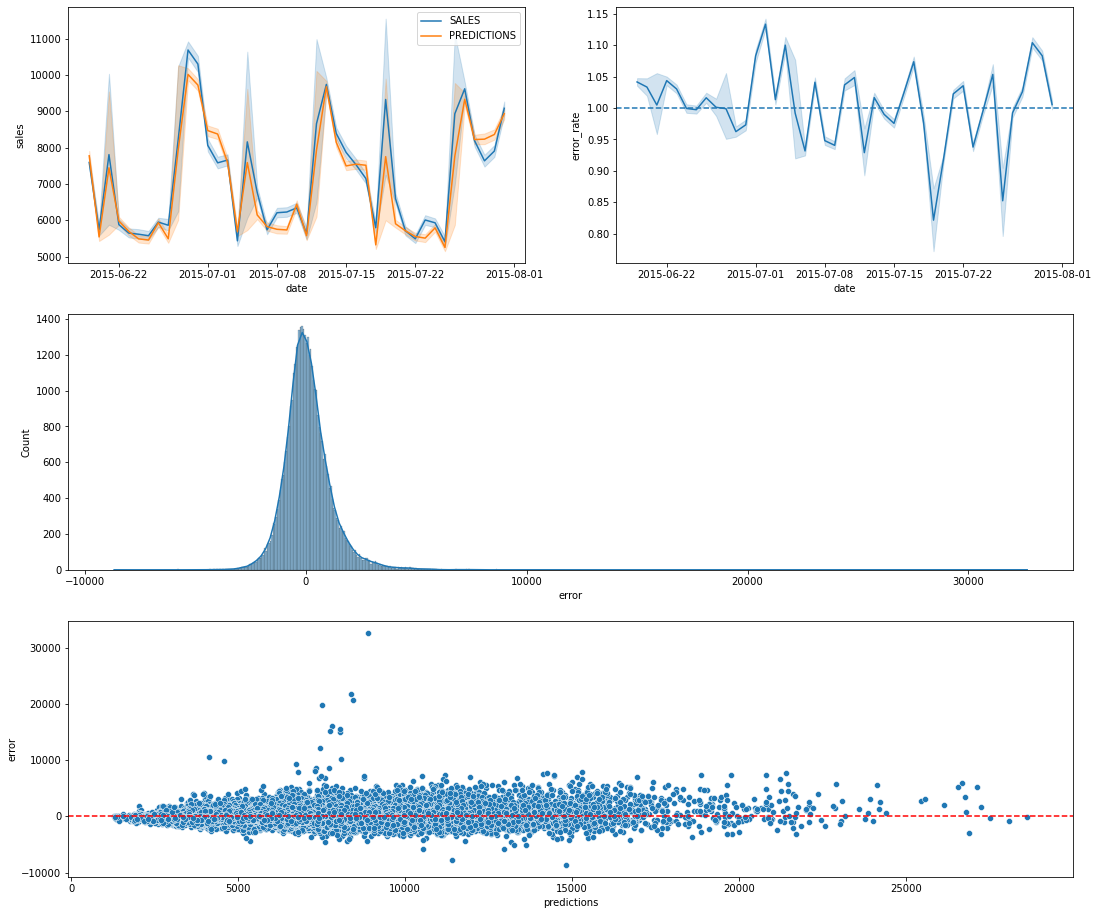

In [134]:
df7['error'] = df7['sales'] - df7['predictions']
df7['error_rate'] = df7['predictions'] / df7['sales'] 

fig,ax = plt.subplot_mosaic("AB;CC;DD",figsize=(18,16))

sns.lineplot(x='date',y='sales',data=df7, label='SALES', ax=ax['A'])
sns.lineplot(x='date',y='predictions',data=df7,label='PREDICTIONS', ax=ax['A'])

sns.lineplot(x='date',y='error_rate', data=df7, ax=ax['B'])
ax['B'].axhline(1, linestyle='--')

sns.histplot(df7['error'],kde=True,ax=ax['C'])

sns.scatterplot(x='predictions',y='error',data=df7,ax=ax['D'])
ax['D'].axhline(0, color='red', linestyle='--');


## 10. Deploy Model to Production

### 10.1 Rossmann Class

In [135]:
#will migrate to Rossmann.py
import pickle
import pandas as pd
import inflection
import numpy as np
import datetime

class Rossmann(object): #encapsulate all transformation made along code (cleaning, transformation, encodes)
    
    #class initialize brings all encoder in pickle files
    def __init__(self):
        self.home_path = 'C:\\Users\\marco\\OneDrive\\Documents\\repos\\ds_em_producao\\rossmann-sales-prediction\\'
        self.competition_distance_scaler =   pickle.load(open(self.home_path+'local\\parameters\\competition_distance_scaler.pkl','rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path+'local\\parameters\\competition_time_month_scaler.pkl','rb'))
        self.promo_time_week_scaler =        pickle.load(open(self.home_path+'local\\parameters\\promo_time_week_scaler.pkl','rb'))
        self.year_scaler =                   pickle.load(open(self.home_path+'local\\parameters\\year_scaler.pkl','rb'))
        self.store_type_encoder =            pickle.load(open(self.home_path+'local\\parameters\\store_type_encoder.pkl','rb'))


    def data_cleaning(self, df):
        
        #transform to snake_case
        cols_old = df.columns
        snake_case = lambda x: inflection.underscore(x)
        cols_new = list(map(snake_case,cols_old))
        df.columns = cols_new

        df['date'] = pd.to_datetime(df['date'],format="%Y-%m-%d")
        df['open'] = df['open'].astype('int64')
        
        #Fill out NAs
        #CompetitionDistance - distance in meters to the nearest competitor store
        df['competition_distance'] = df['competition_distance'].apply(lambda x: 150000 if pd.isna(x) else x)

        #CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
        df['competition_open_since_month'] = df.apply(lambda x: x['date'].month if pd.isna(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)                                                                                          
        df['competition_open_since_year'] = df.apply(lambda x: x['date'].year if pd.isna(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)
                                                                                           

        #Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
        df['promo2_since_week'] = df.apply(lambda x: x['date'].week if pd.isna(x['promo2_since_week']) else x['promo2_since_week'],axis=1)
        df['promo2_since_year'] = df.apply(lambda x: x['date'].year if pd.isna(x['promo2_since_year']) else x['promo2_since_year'],axis=1)

        #PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store
        df['promo_interval'].fillna(0, inplace=True)

        #translates month (in numbers) to month (in string) and check in a new attribute if sale was in active promo
        month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
        df['month_map'] = df['date'].dt.month.map(month_map)
        df['is_promo'] = df[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        df['competition_open_since_month'] = df['competition_open_since_month'].astype('int64')
        df['competition_open_since_year'] = df['competition_open_since_year'].astype('int64')

        df['promo2_since_week'] = df['promo2_since_week'].astype('int64')
        df['promo2_since_year'] = df['promo2_since_year'].astype('int64')
        
        
        return df
    
        
    def feature_engineering(self, df2):
        
        #creating date features
        #year
        df2['year'] = df2['date'].dt.year

        #day
        df2['day'] = df2['date'].dt.day

        #month
        df2['month'] = df2['date'].dt.month

        #week_of_year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        #week-year
        df2['year_week'] = df2['date'].dt.strftime("%Y-%W")

        #competition_since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

        #promo_since
        df2['promo_since'] = df2['promo2_since_year'].astype(str)+'-'+df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')

        #assortment => assortment level: a = basic, b = extra, c = extended
        df2['assortment'] = df2['assortment'].map({'a':'basic', 'b':'extra','c':'extended'})

        #state_holday => a = public holiday, b = Easter holiday, c = Christmas, 0 = None
        df2['state_holiday'] = df2['state_holiday'].map({'a':'public', 'b':'easter','c':'christmas','0':'regular'})
        
        #open == 0 means store closed and we cant predict any sales
        df2 = df2[(df2['open'] != 0)].reset_index(drop=True)

        ### 3.2 Attributes filtering
        cols_drop = ['open','promo_interval','month_map']
        df2 = df2.drop(cols_drop,axis=1)

        return df2
        
        
    def data_preparation(self, df5):
        
        ### 5.2 Rescaling
        #competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values)

        #competition_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values)

        #promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)

        #year
        df5['year'] = self.year_scaler.transform(df5[['year']].values)

        ### 5.3 Transformation

        #### 5.3.1 Encoding

        #state_holiday => its a 'status' condition, fits with One Hot Encoding
        df5 = pd.get_dummies(df5,prefix=['state_holiday'],columns=['state_holiday'])

        #store_type => its a type, fits with Label Enconding
        df5['store_type'] = self.store_type_encoder.transform(df5['store_type'])

        #assortment => there is a order dependency, we can label as ordinal, fits with Ordinal Enconding
        label_enconding_map = {'basic':1, 'extra':2, 'extended':3}
        df5['assortment'] = df5['assortment'].map(label_enconding_map)

        #### 5.3.3 Nature Transformation

        #temporal variables have cyclical behavior thus must show it to model => use trigonometry to derive new attributes

        #day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))

        #month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

        #day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))

        #week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi / 52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi / 52)))
       
    
        cols_selected = ['store', 'promo', 'store_type','assortment', 'competition_distance','competition_open_since_month',
                         'competition_open_since_year', 'promo2','promo2_since_week','promo2_since_year','competition_time_month',
                         'promo_time_week','day_of_week_sin','day_of_week_cos','month_sin','month_cos', 'day_sin', 'day_cos',
                         'week_of_year_sin','week_of_year_cos']
        
        return df5[cols_selected]

    def get_prediction(self, model, original_data, test_data):
        
        #prediction
        pred = model.predict(test_data)
        
        #join prediction into original data
        original_data['prediction'] = np.expm1(pred)
        
        #returning to API in JSON format
        return original_data.to_json(orient='records',date_format='iso')

### 10.2 API Handler

In [139]:
#will migrate to handler.py
from flask import Flask, request,Response
from rossmann.Rossmann import Rossmann
import pickle
import pandas as pd

#loading model
model = pickle.load(open('C:\\Users\\marco\\OneDrive\\Documents\\repos\\ds_em_producao\\rossmann-sales-prediction\\local\\model\\model_rossmann.pkl', 'rb'))

#initialize API
app = Flask(__name__)


#define endpoint
@app.route('/rossmann/predict',methods=['POST'])
def rossmann_predict():

    #getting input
    test_json = request.get_json()
    
    #testing data input
    if test_json: #data ok
        
        if isinstance(test_json,dict): #only 1 line
            test_raw = pd.DataFrame(test_json,index=[0])
        
        else: #many 
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
    else: #empty
        return Response({}, status=200, mimetype='application/json') 
    
    
    #instantiate class    
    pipeline = Rossmann()
    
    #data cleaning
    df1 = pipeline.data_cleaning(test_raw)

    #feature engineering
    df2 = pipeline.feature_engineering(df1)
    
    #data preparation
    df3 = pipeline.data_preparation(df2)
    
    #predict
    df_response = pipeline.get_prediction(model, test_raw, df3)
    
    return df_response


if __name__ == '__main__':
    app.run('192.168.1.201',debug=True) #running in local host



 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with stat


SystemExit: 1

### 10.3 API Tester

In [248]:
df10 = pd.read_csv('C:\\Users\\marco\\OneDrive\\Documents\\repos\\ds_em_producao\\rossmann-sales-prediction\\datasets\\test.csv',low_memory=False)

#merge test dataset + stores info
df_test= pd.merge (df10, df_store_raw,how='left',on='Store')

#choose store to prediction
df_test = df_test[df_test['Store'].isin( [40, 50, 90] )]

#remove closed days
df_test = df_test[df_test['Open']!=0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id',axis=1)

#convert df to json to communicate to api
data = json.dumps(df_test.to_dict(orient='records'))

In [249]:
#API call
url = 'http://192.168.1.201:5000/rossmann/predict'
header = {'Content-type':'application/json'}

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [251]:
d1 = pd.DataFrame(r.json(),columns=r.json()[0].keys())

d2 = d1[['store','prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell EUR{:.2f} in next 6 weeks'.format(d2.loc[i,'store'],d2.loc[i,'prediction']))

Store Number 40 will sell EUR199923.02 in next 6 weeks
Store Number 50 will sell EUR192354.61 in next 6 weeks
Store Number 90 will sell EUR303075.75 in next 6 weeks
